This unit runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

本单元贯穿机器学习中常见任务的 API。 请参阅每个部分中的链接以深入了解。

## Working with data
PyTorch has two primitives to work with data: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``. ``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around the ``Dataset``.

PyTorch 有两个原语来处理数据：``torch.utils.data.DataLoader`` 和``torch.utils.data.Dataset``。 ``Dataset`` 存储样本及其相应的标签，``DataLoader`` 将一个可迭代对象包装在``Dataset`` 周围。



In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

PyTorch offers domain-specific libraries such as `TorchText`, `TorchVision`, and `TorchAudio`, all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like CIFAR and COCO. In this tutorial, we'll use the **FashionMNIST** dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and ``target_transform`` to modify the samples and labels respectively.


PyTorch 提供特定领域的库，例如``TorchText``、``TorchVision``和``TorchAudio``，所有这些库都包含数据集。 对于本教程，我们将使用 TorchVision 数据集。

``torchvision.datasets`` 模块包含许多真实世界视觉数据（如 CIFAR 和 COCO）的 ``Dataset`` 对象。 在本教程中，我们将使用 **FashionMNIST** 数据集。 每个 TorchVision ``Dataset`` 包括两个参数：``transform`` 和 ``target_transform`` 分别修改样本和标签。

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

我们将 ``Dataset`` 作为参数传递给 ``DataLoader``。 这在我们的数据集上包装了一个可迭代对象，并支持自动批处理、采样、混洗和多进程数据加载。 这里我们定义了一个 64 的批量大小，即数据加载器迭代器中的每个元素将返回一批 64 个特征和标签。


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


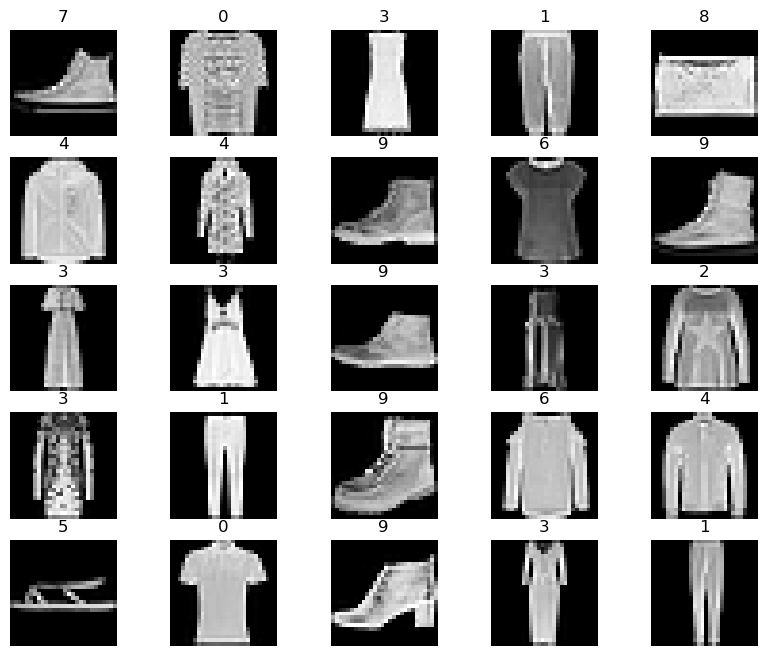

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break
    
# Display sample data
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating models
To define a neural network in PyTorch, we create a class that inherits from `nn.Module`. We define the layers of the network in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate operations in the neural network, we move it to the GPU if available.

为了在 PyTorch 中定义神经网络，我们创建了一个继承自 ``nn.Module`` 的类。 我们在 ``__init__`` 函数中定义网络层，并在 ``forward`` 函数中指定数据如何通过网络。 为了加速神经网络中的操作，我们将其移至 GPU（如果可用）。


In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


## Optimizing the Model Parameters
To train a model, we need a loss function and an optimizer.  We'll be using `nn.CrossEntropyLoss` for loss and `Stochastic Gradient Descent` for optimization.

要训练模型，我们需要一个损失函数和一个优化器。 我们将使用 `nn.CrossEntropyLoss` 进行损失，使用 `Stochastic Gradient Descent` 进行优化。

In [5]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and back-propagates the prediction error to adjust the model's parameters. 

在单个训练循环中，模型对训练数据集（分批输入）进行预测，并反向传播预测误差以调整模型的参数。



In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We can also check the model's performance against the test dataset to ensure it is learning.

我们还可以根据测试数据集检查模型的性能，以确保它正在学习。


In [7]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the accuracy increase and the loss decrease with every epoch.

训练过程进行了几次迭代 (*epochs*)。 在每个时期，模型学习参数以做出更好的预测。 我们在每个时期打印模型的准确性和损失； 我们希望看到每个时期的准确性都在提高，损失在减少。



In [8]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.311343  [    0/60000]
loss: 2.304144  [ 6400/60000]
loss: 2.288939  [12800/60000]
loss: 2.278725  [19200/60000]
loss: 2.269172  [25600/60000]
loss: 2.255497  [32000/60000]
loss: 2.256589  [38400/60000]
loss: 1.915722  [38400/60000]
loss: 1.892751  [44800/60000]
loss: 1.863119  [51200/60000]
loss: 1.780312  [57600/60000]
Test Error: 
 Accuracy: 55.6%, Avg loss: 0.028011 

Epoch 4
-------------------------------
loss: 1.855736  [    0/60000]
loss: 1.760127  [ 6400/60000]
loss: 1.677681  [12800/60000]
loss: 1.710101  [19200/60000]
loss: 1.573927  [25600/60000]
loss: 1.697329  [32000/60000]
loss: 1.657596  [38400/60000]
loss: 1.669964  [44800/60000]
loss: 1.624707  [51200/60000]
loss: 1.512079  [57600/60000]
Test Error: 
 Accuracy: 58.2%, Avg loss: 0.024207 

Epoch 5
-------------------------------
loss: 1.642810  [    0/60000]
loss: 1.524957  [ 6400/60000]
loss: 1.439776  [12800/60000]
loss: 1.487713  [19200/60000]
loss: 1.334362  [25600/600

The accuracy will initially not be very good (that's OK!). Try running the loop for more `epochs` or adjusting the `learning_rate` to a bigger number. It might also be the case that the model configuration we chose might not be the optimal one for this kind of problem (it isn't). Later courses will delve more into the model shapes that work for vision problems.


准确性最初不会很好（没关系！）。 尝试运行循环以获得更多的``epochs``或将``learning_rate``调整为更大的数字。 也可能是我们选择的模型配置可能不是此类问题的最佳配置（事实并非如此）。 以后的课程将更多地研究适用于视力问题的模型形状。

Saving Models
-------------
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

保存模型的常用方法是序列化内部状态字典（包含模型参数）。



In [9]:
torch.save(model.state_dict(), "data/model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models
----------------------------

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it. 

加载模型的过程包括重新创建模型结构和加载
状态字典放入其中。



In [10]:
model = NeuralNetwork()
model.load_state_dict(torch.load("data/model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.

该模型现在可用于进行预测。

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Congratulations! You have completed the PyTorch beginner tutorial! We hope this tutorial has helped you get started with deep learning on PyTorch.

恭喜！ 您已经完成了 PyTorch 初学者教程！ 我们希望本教程能帮助您开始在 PyTorch 上进行深度学习。